In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema


In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Work\Projects\\python\\flask\strategies\\igdata'

In [4]:
pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['naturalgas_15Min', 'naturalgas_1H', 'naturalgas_4H', 'naturalgas_5Min', 'naturalgas_D']


In [5]:

df = {}
dd = {}

for pair in range(len(pairs_list)):
    t = str(pairs_list[pair].split('_')[1])
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 2)
    #df[pair].drop([4,5,6,7,8,9,10,11,12], axis=01)
    #df[pair] = df[pair].iloc[0,1,2,3,4,13]
    df[pair] = df[pair].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
    df[pair].columns = ['Date', 'Bid Open', 'Bid High', 'Bid Low', 'Bid Close',\
                                'Ask Open', 'Ask High', 'Ask Low', 'Ask Close',\
                                'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Open'] = df[pair]['Bid Open']
    df[pair]['High'] = df[pair]['Bid High']
    df[pair]['Low'] = df[pair]['Bid Low']
    df[pair]['Close'] = df[pair]['Bid Close']
    #df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    #df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y.%m.%d %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''
    dd[t] = df[pair]
    
for key in dd:
    print(f'Key: {key} - rows: {len(dd[key])}')


Key: 15Min - rows: 9503
Key: 1H - rows: 5913
Key: 4H - rows: 1598
Key: 5Min - rows: 8461
Key: D - rows: 939


In [6]:
def SMA(df, period):
    df[str(period) + '_sma'] = df['Close'].rolling(period).mean()
    return df[str(period) + '_sma']

def EMA(df, period):
    df[str(period) + '_ema'] = df['Close'].ewm(span = period,adjust=False).mean()
    return  df[str(period) + '_ema']

def PriceCrossover(df, price_col, indicator_col):
    conditions  = [ (df[indicator_col].shift(1) > df[price_col].shift(1)) & (df[indicator_col] < df[price_col]),\
                    (df[indicator_col].shift(1) < df[price_col].shift(1)) & (df[indicator_col] > df[price_col])]
    choices     = ['BreakUp','BreakDown']
    df[price_col +'_'+ indicator_col + '_crossover'] = np.select(conditions, choices, default=np.nan)
    df[price_col +'_'+ indicator_col + '_crossover_price'] = np.where(df[price_col +'_'+ indicator_col + '_crossover']==\
                                                                      'nan','nan',df[price_col])
    return  df

def Trend(df):
    conditions  = [df['200_sma'] > df['400_sma'], df['200_sma'] < df['400_sma']]
    choices     = ['Up','Down']
    df['Trend'] = np.select(conditions, choices, default=np.nan)
    return  df['Trend']


def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5
spread = 2
plot_trades = False
pair = '1H'

In [8]:
for res in dd:
    price = dd[res]['Close']
    #SMA(df[pair], 200).to_csv('200sma.csv')
    dd[res]['400_sma'] = SMA(dd[res], 400)
    dd[res]['200_sma'] = SMA(dd[res], 200)
    dd[res]['100_sma'] = SMA(dd[res], 100)
    dd[res]['50_sma'] = SMA(dd[res], 50)
    dd[res]['20_sma'] = SMA(dd[res], 20)
    dd[res]['9_ema'] = EMA(dd[res], 9)
    dd[res]['Trend'] = Trend(dd[res])
    dd[res]['Close_9_ema_crossover'] = PriceCrossover(dd[res], 'Close','9_ema')['Close_9_ema_crossover']
    dd[res]['9_ema_20_sma_crossover'] = PriceCrossover(dd[res], '9_ema','20_sma')['9_ema_20_sma_crossover']
    
    dd[res].to_csv(f'NG_{res}.csv')
    
    #plt.figure(figsize = (26, 6))
    
    #plt2.title("Stock Price Chart " +  res)
    #Plot line chart
    #plt.plot(dd[res]['Close'], label='Prices',color = 'black')
    #plt.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')
    #plt.scatter(dd[res].index, np.where(dd[res]['Close_9_ema_crossover']!=np.nan, dd[res]['Close_9_ema_crossover_price'] ,np.nan),  s = 20, color = 'green')
    #plt.scatter(dd[res].index, dd[res]['Close_9_ema_crossover_price'],  s = 20, color = 'green')
    #plt.legend()
    #plt.figure()

    #Plot candlestick Chart
    
    #create figure
    #plt2.figure(figsize = (26, 6))

    #plt2.title("Stock Price Chart " +  res)
        
    #define width of candlestick elements
    #width = .4
    #width2 = .1

    #define up and down prices
    #up = dd[res][dd[res].Close >= dd[res].Open]
    #down = dd[res][dd[res].Close < dd[res].Open]

    #define colors to use
    #col1 = 'green'
    #col2 = 'red'

    #plot up prices
    #plt2.bar(up.index,up.Close - up.Open, width, bottom = up.Open,color=col1)
    #plt2.bar(up.index,up.High - up.Close, width2, bottom = up.Close,color=col1)
    #plt2.bar(up.index,up.Low - up.Open, width2, bottom = up.Open,color=col1)

    #plot down prices
    #plt2.bar(down.index,down.Close - down.Open, width, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.High - down.Open, width2, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.Low - down.Close, width2, bottom=down.Close,color=col2)

    #plot moving averages
    #plt2.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt2.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt2.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt2.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt2.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')

    #rotate x-axis tick labels
    #plt2.xticks(rotation=45, ha='right')

    #display candlestick chart
    #plt2.show()

In [9]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

# Open trade when candle close above or below 9ema after touching 50, 100 or 200sma

In [146]:


open_trade[pair] = []
trade[pair] = {}
long_take_profit[pair] = []
short_take_profit[pair] = []
long_stop_loss[pair] = []
short_stop_loss[pair] = []
long_entry_price[pair] = []
short_entry_price[pair] = []

support[pair] = []
resist[pair] = []
stop_loss_margin = 20
max_stop_loss_distance = 450
balance = 10000
dd[pair]['buy'] = np.nan
dd[pair]['sell'] = np.nan
dd[pair]['exit'] = np.nan
dd[pair]['sl'] = np.nan
dd[pair]['tp'] = np.nan
print([pair])
pd.options.mode.chained_assignment = None 

for i in range(50, len(dd[pair])):

    size = 1
    #size = int(100 * float(size)/float(balance))
    #print(str(size))
    #print('size', size)
     
    #buy_stop_loss_distance = dd[pair]['Close'][i] - buy_stop_loss
    buy_stop_loss = dd[pair]['Close'][i] - max_stop_loss_distance

    #sell_stop_loss_distance = dd[pair]['Close'][i] + sell_stop_loss
    sell_stop_loss = dd[pair]['Close'][i] + max_stop_loss_distance
    
   # if(buy_stop_loss_distance > max_stop_loss_distance):
   #     buy_stop_loss = dd[pair]['Close'][i-1] - max_stop_loss_distance
    
   # if(sell_stop_loss_distance > max_stop_loss_distance):
   #     sell_stop_loss = dd[pair]['Close'][i-1] + max_stop_loss_distance

    
    #Exit trades---------------------------------------------------------------------------

    #Buy loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            #print(f'Checking Low: {str(dd[pair]['Low'][i-1])} against SL:{str(trade[pair][j]['SL'])}')
            if(dd[pair]['Low'][i-1] <= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking Low:')
                print(dd[pair]['Low'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
                trade[pair][j].update({'result' : (trade[pair][j]['SL'] - (trade[pair][j]['entry_price'] + spread)) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Long loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])
                
    #Buy profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if(dd[pair]['9_ema_20_sma_crossover'][i-1] == 'BreakDown' or \
               dd[pair]['Close'][i] > (dd[pair]['Close'][i] - dd[pair]['9_ema'][i]) > 100):
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                dd[pair]['exit'][i]=dd[pair]['Close'][i]
                print(j,
                     'Long profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
           # else:
           #     trade[pair][j].update({'SL' : buy_stop_loss})
           #     dd[pair]['sl'][i] = buy_stop_loss
                #print(trade[pair])
                #print('moved SL:', trade[pair][j]['SL'])

            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

    
    
    #Sell Loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            #print(f'Checking High: {dd[pair]['High'][i-1]} against SL:{trade[pair][j]['SL']}')
            if(dd[pair]['High'][i-1] >= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking High:')
                print(dd[pair]['High'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
            
                trade[pair][j].update({'result' : ((trade[pair][j]['entry_price'] - spread) - trade[pair][j]['SL'] ) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Short loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])


    #Sell profit
    
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if(dd[pair]['9_ema_20_sma_crossover'][i-1] == 'BreakUp'  or \
               dd[pair]['Close'][i] < (dd[pair]['9_ema'][i] - dd[pair]['Close'][i]) > 100):
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - (dd[pair]['Close'][i] - spread) * size)})
                dd[pair]['exit'][i]=round(dd[pair]['Close'][i], 4)
                print('Short profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            #else:
            #    trade[pair][j].update({'SL' : sell_stop_loss})
            #    dd[pair]['sl'][i] = sell_stop_loss
                #print(trade[pair])
                #print('moved SL:', trade[pair][j]['SL'])
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

        
    #Buy
    
    #When price touches 200MA and closed above 9EMA 
    if(((dd[pair]['Close'][i] > dd[pair]['200_sma'][i] and \
         dd[pair]['High'][i] <= dd[pair]['200_sma'][i] and \
         dd[pair]['Close'][i] > dd[pair]['9_ema'][i] and \
         dd[pair]['100_sma'][i] < dd[pair]['9_ema'][i] and \
         dd[pair]['9_ema'][i] > dd[pair]['200_sma'][i])) and \
       len(open_trade[pair]) == 0):
            print('Price touches 200MA and closed above 9EMA')
            #buy_stop_loss = min(dd[pair]['Low'][i],dd[pair]['200_sma'][i], dd[pair]['9_ema'][i],dd[pair]['100_ema'][i]) 

            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue

    # When price touches 100MA and closes above 9EMA
    if(((dd[pair]['Close'][i] > dd[pair]['100_sma'][i] and dd[pair]['Low'][i] <= dd[pair]['100_sma'][i] and \
         dd[pair]['Close'][i] > dd[pair]['9_ema'][i] and \
         dd[pair]['9_ema'][i] > dd[pair]['100_sma'][i])) and \
       len(open_trade[pair]) == 0):
            print('Price touches 100MA and closed above 9EMA')
            #buy_stop_loss = min(dd[pair]['Low'][i],dd[pair]['100_sma'][i], dd[pair]['9_ema'][i]) 
            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue
      
    # When price touches 50MA and closes above 9EMA
    if(((dd[pair]['Close'][i] > dd[pair]['50_sma'][i] and dd[pair]['Low'][i] <= dd[pair]['50_sma'][i] and \
         dd[pair]['Close'][i] > dd[pair]['9_ema'][i] and \
         dd[pair]['50_sma'][i] > dd[pair]['100_sma'][i])) and \
       len(open_trade[pair]) == 0):
            print('Price touches 50MA and closed above 9EMA')
            #buy_stop_loss = min(dd[pair]['Low'][i],dd[pair]['50_sma'][i], dd[pair]['9_ema'][i])
            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue
    
    # If there is a cross-over of 9EMA vs 20MA
    if(((dd[pair]['9_ema_20_sma_crossover'][i] == 'BreakUp' and dd[pair]['50_sma'][i] < dd[pair]['9_ema'][i] and dd[pair]['100_sma'][i] < dd[pair]['9_ema'][i] and dd[pair]['200_sma'][i] < dd[pair]['9_ema'][i])) and len(open_trade[pair]) == 0):
            print('Price 9_ema 20MA cross over - breakUp')
            #buy_stop_loss = min(dd[pair]['Low'][i],dd[pair]['50_sma'][i], dd[pair]['9_ema'][i],dd[pair]['20_sma'][i],dd[pair]['100_sma'][i])
            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue
            
            
    #Sell
    
    # When price touches 200MA and closes below 9EMA
    if((dd[pair]['Close'][i] < dd[pair]['200_sma'][i] and dd[pair]['High'][i] >= dd[pair]['200_sma'][i] and dd[pair]['Close'][i] < dd[pair]['9_ema'][i] and dd[pair]['100_sma'][i] > dd[pair]['9_ema'][i] and dd[pair]['9_ema'][i] < dd[pair]['200_sma'][i]) and \
    len(open_trade[pair]) == 0):
            print('Price touches 200MA and closes below 9_ema')
            #sell_stop_loss = max(dd[pair]['High'][i],dd[pair]['200_sma'][i], dd[pair]['9_ema'][i], dd[pair]['100_sma'][i])
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue
            
    # When price touches 100MA and closes below 9EMA
    if((dd[pair]['Close'][i] < dd[pair]['100_sma'][i] and dd[pair]['High'][i] >= dd[pair]['100_sma'][i] and dd[pair]['Close'][i] < dd[pair]['9_ema'][i] and dd[pair]['9_ema'][i] < dd[pair]['100_sma'][i]) and \
    len(open_trade[pair]) == 0):
            print('Price touches 100MA and closes below 9_ema')
            #sell_stop_loss = max(dd[pair]['High'][i],dd[pair]['100_sma'][i], dd[pair]['9_ema'][i])
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue
            
    # When price touches 50MA and closes below 9EMA
    if((dd[pair]['Close'][i] < dd[pair]['50_sma'][i] and dd[pair]['High'][i] >= dd[pair]['50_sma'][i] and dd[pair]['Close'][i] < dd[pair]['9_ema'][i] and dd[pair]['50_sma'][i] < dd[pair]['100_sma'][i]) and \
    len(open_trade[pair]) == 0):
            print('Price touches 50MA and closes below 9_ema')
            #sell_stop_loss = max(dd[pair]['High'][i],dd[pair]['50_sma'][i], dd[pair]['9_ema'][i])
            print('dd[pair][High][i] :',dd[pair]['High'][i]) 
            print('dd[pair][50_sma][i] :',dd[pair]['50_sma'][i]) 
            print('dd[pair][Close][i] :',dd[pair]['Close'][i]) 
            print('dd[pair][9_ema][i] :',dd[pair]['9_ema'][i])
            print('dd[pair][100_ema][i] :',dd[pair]['100_sma'][i])
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue


    # When price crossover 9_ema and 20ma
    if((dd[pair]['9_ema_20_sma_crossover'][i] == 'BreakDown' and dd[pair]['50_sma'][i] > dd[pair]['9_ema'][i] and dd[pair]['100_sma'][i] > dd[pair]['9_ema'][i] and dd[pair]['200_sma'][i] > dd[pair]['9_ema'][i]) and \
    len(open_trade[pair]) == 0):
            print('Price crossover 9EMA-20MA')
            #sell_stop_loss = max(dd[pair]['Low'][i],dd[pair]['50_sma'][i], dd[pair]['9_ema'][i],dd[pair]['20_sma'][i],dd[pair]['100_sma'][i])
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue


['1H']
Price touches 50MA and closed above 9EMA
New Long trade at price: 4837.0  On day: 2022-03-04 11:00:00
With stop loss at  4387.0
9EMA-20MA cross
104 Long profit/loss at price: 5022.0 On day: 2022-03-04 18:00:00 With profit/loss: 183.0 

Price touches 50MA and closes below 9_ema
dd[pair][High][i] : 4625.0
dd[pair][50_sma][i] : 4580.06
dd[pair][Close][i] : 4579.0
dd[pair][9_ema][i] : 4584.393111230062
dd[pair][100_ema][i] : 4746.72
New Short trade at price: 4579.0  On day: 2022-03-10 11:00:00
With stop loss at  5029.0
9EMA-20MA cross
Short profit/loss at price: 4693.0 On day: 2022-03-14 20:00:00 With profit/loss: -112.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 4693.0  On day: 2022-03-14 20:00:00
With stop loss at  4243.0
9EMA-20MA cross
252 Long profit/loss at price: 4620.0 On day: 2022-03-15 04:00:00 With profit/loss: -75.0 

Price touches 100MA and closes below 9_ema
New Short trade at price: 4600.0  On day: 2022-03-15 06:00:00
With stop loss at  5050.0

New Short trade at price: 8440.0  On day: 2022-06-02 15:00:00
With stop loss at  8890.0
Stop loss hit
Checking High:
8943.0
Against SL
8890.0
Short loss at price: 8890.0 On day: 2022-06-02 16:00:00 Reason: Stopped out With loss: -452.0 

Price touches 50MA and closes below 9_ema
dd[pair][High][i] : 8557.0
dd[pair][50_sma][i] : 8523.5
dd[pair][Close][i] : 8516.0
dd[pair][9_ema][i] : 8700.425941330364
dd[pair][100_ema][i] : 8621.06
New Short trade at price: 8516.0  On day: 2022-06-02 16:00:00
With stop loss at  8966.0
9EMA-20MA cross
Short profit/loss at price: 8424.0 On day: 2022-06-03 14:00:00 With profit/loss: 94.0 

Price touches 100MA and closes below 9_ema
New Short trade at price: 8424.0  On day: 2022-06-03 14:00:00
With stop loss at  8874.0
Stop loss hit
Checking High:
8889.0
Against SL
8874.0
Short loss at price: 8874.0 On day: 2022-06-06 11:00:00 Reason: Stopped out With loss: -452.0 

Price 9_ema 20MA cross over - breakUp
New Long trade at price: 9404.0  On day: 2022-06-08 01:

9EMA-20MA cross
2854 Long profit/loss at price: 9402.0 On day: 2022-08-22 08:00:00 With profit/loss: 144.0 

Price touches 50MA and closes below 9_ema
dd[pair][High][i] : 9375.0
dd[pair][50_sma][i] : 9300.0
dd[pair][Close][i] : 9286.0
dd[pair][9_ema][i] : 9294.080816784579
dd[pair][100_ema][i] : 9399.48
New Short trade at price: 9286.0  On day: 2022-08-25 16:00:00
With stop loss at  9736.0
9EMA-20MA cross
Short profit/loss at price: 9481.0 On day: 2022-08-29 05:00:00 With profit/loss: -193.0 

Price touches 100MA and closed above 9EMA
New Long trade at price: 9477.0  On day: 2022-08-29 07:00:00
With stop loss at  9027.0
9EMA-20MA cross
2969 Long profit/loss at price: 9274.0 On day: 2022-08-29 14:00:00 With profit/loss: -205.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 9431.0  On day: 2022-08-29 15:00:00
With stop loss at  8981.0
Stop loss hit
Checking Low:
8887.0
Against SL
8981.0
Long loss at price: 8981.0 On day: 2022-08-30 15:00:00 Reason: Stopped out With l

New Long trade at price: 6495.0  On day: 2022-11-18 14:00:00
With stop loss at  6045.0
9EMA-20MA cross
4329 Long profit/loss at price: 6598.0 On day: 2022-11-18 15:00:00 With profit/loss: 101.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 6598.0  On day: 2022-11-18 15:00:00
With stop loss at  6148.0
9EMA-20MA cross
4330 Long profit/loss at price: 6792.0 On day: 2022-11-21 13:00:00 With profit/loss: 192.0 

Price 9_ema 20MA cross over - breakUp
New Long trade at price: 7279.0  On day: 2022-11-22 15:00:00
With stop loss at  6829.0
9EMA-20MA cross
4376 Long profit/loss at price: 7396.0 On day: 2022-11-22 16:00:00 With profit/loss: 115.0 

Price 9_ema 20MA cross over - breakUp
New Long trade at price: 7591.0  On day: 2022-11-24 15:00:00
With stop loss at  7141.0
9EMA-20MA cross
4422 Long profit/loss at price: 7519.0 On day: 2022-11-24 17:00:00 With profit/loss: -74.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 7607.0  On day: 2022-11-24 19:00:

Short profit/loss at price: 2529.0 On day: 2023-02-14 09:00:00 With profit/loss: -36.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 2568.0  On day: 2023-02-14 11:00:00
With stop loss at  2118.0
9EMA-20MA cross
5699 Long profit/loss at price: 2620.0 On day: 2023-02-15 08:00:00 With profit/loss: 50.0 

Price touches 50MA and closed above 9EMA
New Long trade at price: 2591.0  On day: 2023-02-16 07:00:00
With stop loss at  2141.0
9EMA-20MA cross
5741 Long profit/loss at price: 2450.0 On day: 2023-02-16 18:00:00 With profit/loss: -143.0 

Price crossover 9EMA-20MA
New Short trade at price: 2291.0  On day: 2023-02-21 02:00:00
With stop loss at  2741.0
9EMA-20MA cross
Short profit/loss at price: 2326.0 On day: 2023-02-21 08:00:00 With profit/loss: -33.0 

Price touches 50MA and closes below 9_ema
dd[pair][High][i] : 2336.0
dd[pair][50_sma][i] : 2330.68
dd[pair][Close][i] : 2300.0
dd[pair][9_ema][i] : 2318.5369272446405
dd[pair][100_ema][i] : 2440.68
New Short trade at p

In [147]:
 print(len(open_trade[pair]))

1


In [148]:
dd

{'15Min':                      Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
 Date                                                                    
 2022-10-02 23:00:00    6841.0    6873.0   6781.0     6795.0    6850.0   
 2022-10-02 23:15:00    6796.0    6804.0   6778.0     6787.0    6799.0   
 2022-10-02 23:30:00    6792.0    6797.0   6778.0     6786.0    6801.0   
 2022-10-02 23:45:00    6788.0    6803.0   6784.0     6799.0    6794.0   
 2022-10-03 00:00:00    6798.0    6799.0   6789.0     6790.0    6804.0   
 ...                       ...       ...      ...        ...       ...   
 2023-02-27 18:00:00    2710.0    2710.0   2687.0     2696.0    2713.0   
 2023-02-27 18:15:00    2697.0    2700.0   2688.0     2696.0    2700.0   
 2023-02-27 18:30:00    2697.0    2710.0   2680.0     2686.0    2700.0   
 2023-02-27 18:45:00    2687.0    2708.0   2687.0     2708.0    2690.0   
 2023-02-27 19:00:00    2709.0    2719.0   2699.0     2710.0    2712.0   
 
                      Ask H

In [149]:
dd[pair].drop(['min','max','Bid Open','Bid High','Bid Low','Bid Close','Ask Open','Ask High','Ask Low','Ask Close'], inplace=True, axis=1)
print('columns dropped')
dd[pair].to_csv(f'NG_{pair}_results.csv')
print('csv saved')

KeyError: "['min' 'max' 'Bid Open' 'Bid High' 'Bid Low' 'Bid Close' 'Ask Open'\n 'Ask High' 'Ask Low' 'Ask Close'] not found in axis"

In [150]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [151]:
trade[pair]

{104: {'ID': 104,
  'date_of_trade': Timestamp('2022-03-04 11:00:00'),
  'day_of_trade': 'Fri',
  'entry_price': 4837.0,
  'signal': 'Buy',
  'result': 183.0,
  'TP': nan,
  'SL': 4387.0},
 196: {'ID': 196,
  'date_of_trade': Timestamp('2022-03-10 11:00:00'),
  'day_of_trade': 'Thu',
  'entry_price': 4579.0,
  'signal': 'Sell',
  'result': -112.0,
  'TP': nan,
  'SL': 5029.0},
 252: {'ID': 252,
  'date_of_trade': Timestamp('2022-03-14 20:00:00'),
  'day_of_trade': 'Mon',
  'entry_price': 4693.0,
  'signal': 'Buy',
  'result': -75.0,
  'TP': nan,
  'SL': 4243.0},
 261: {'ID': 261,
  'date_of_trade': Timestamp('2022-03-15 06:00:00'),
  'day_of_trade': 'Tue',
  'entry_price': 4600.0,
  'signal': 'Sell',
  'result': -44.0,
  'TP': nan,
  'SL': 5050.0},
 283: {'ID': 283,
  'date_of_trade': Timestamp('2022-03-16 05:00:00'),
  'day_of_trade': 'Wed',
  'entry_price': 4690.0,
  'signal': 'Buy',
  'result': 279.0,
  'TP': nan,
  'SL': 4240.0},
 345: {'ID': 345,
  'date_of_trade': Timestamp('2022

In [152]:
    
profits[pair] = []
losses[pair] = []
be[pair] = []

pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
#pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
pairs_results[pair].set_index('date_of_trade', inplace = True)
pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

for t in trade[pair]:
    profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
    losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
    be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Returns of each pair')

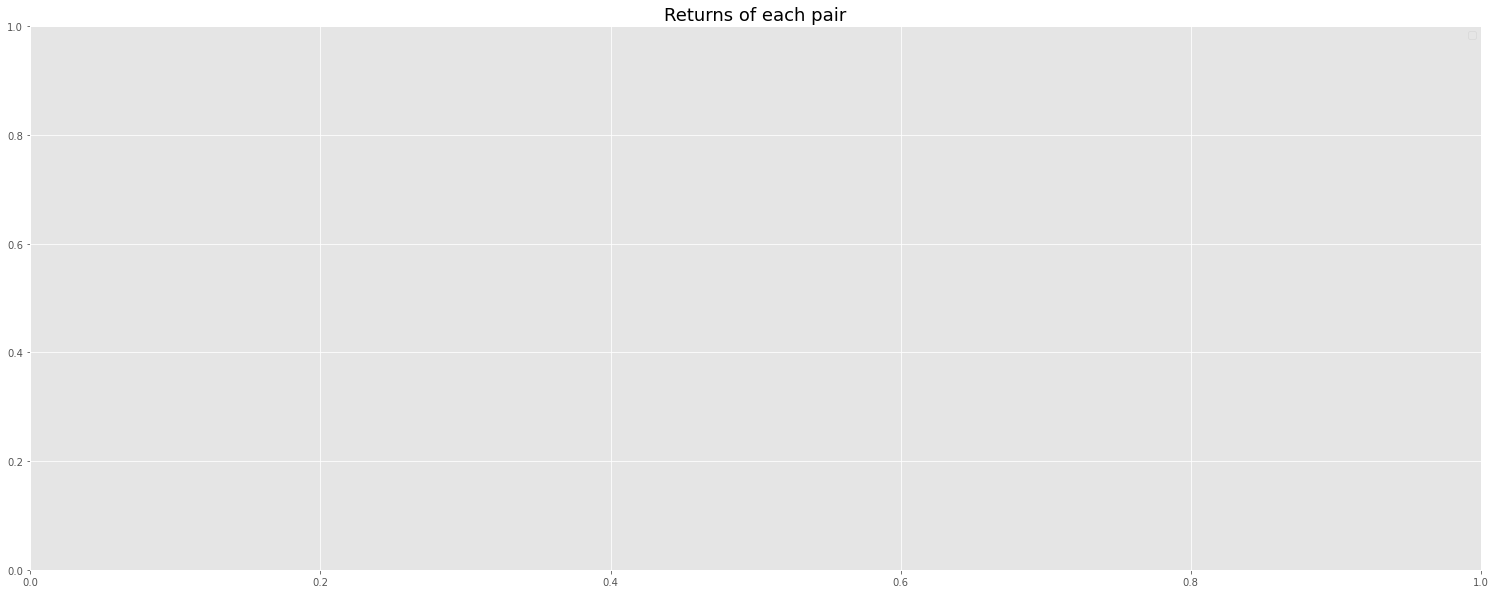

In [153]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
#for pair in range(len(pairs_list)):
#    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [154]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
#print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
#print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
#print('Max profitable trade:', round(max(str_profits), 2))
#print('Max lossing trade:', round(min(str_losses), 2))

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 46.2 %
Sharpe ratio: -0.05
Maximum drawdown 17.84 % 

Number of trades: 169
Number of profits: 91
Number of losses: 76
Number of breakevens: 2 

Winning percentage 54.49 %
ROI: 8165
--------------------------------


Text(0.5, 1.0, 'return of strategy')

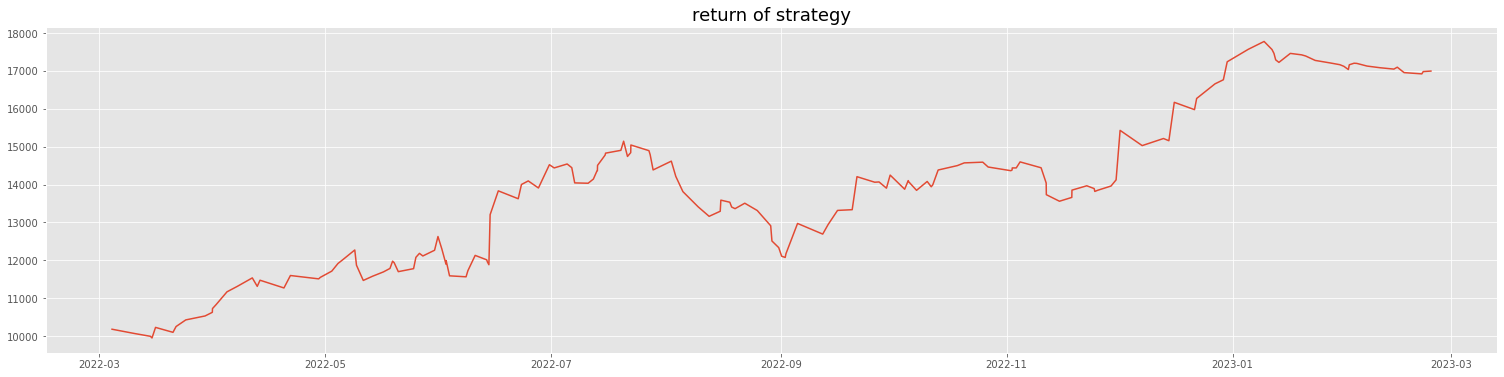

In [100]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


In [ ]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    #print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    #print('Number of profits:', len(profits[pair]))
    #print('Number of losses:', len(losses[pair]))
    #print('Number of breakevens:', len(be[pair]), '\n')
    #print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    #print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    #print('--------------------------------')
    #print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    #print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    #print('Max profitable trade:', round(max(profits[pair]), 2))
    #print('Max lossing trade:', round(min(losses[pair]), 2))
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()
